Imports

In [64]:
import os

from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom, norm, poisson

os.chdir('/app')

from src.web_scraping.scraper import scrap_games

Input parameters for scraping

In [65]:
years = list(range(2022, 2024))
train_year = years[0]
pred_year = years[1]

Scraping

In [66]:
scrap_games(years)

Read data

In [67]:
path = 'src/data/'
path_games = os.path.join(path, 'games/')
seasons_games = {}

# prepare dataframes - drop duplicated rows and sort by date
for year in years:
    seasons_games[year] = pd.read_csv(os.path.join(path_games, f'{year-1}_{year}_season.csv')).drop_duplicates().sort_values(by='start_time').reset_index(drop=True)
print(seasons_games)

{2022:                      start_time              away_team  away_team_score  \
0     2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1     2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2     2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3     2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4     2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   
...                         ...                    ...              ...   
1318  2022-06-06 00:00:00+00:00         BOSTON CELTICS               88   
1319  2022-06-09 01:00:00+00:00  GOLDEN STATE WARRIORS              100   
1320  2022-06-11 01:00:00+00:00  GOLDEN STATE WARRIORS              107   
1321  2022-06-14 01:00:00+00:00         BOSTON CELTICS               94   
1322  2022-06-17 01:00:00+00:00  GOLDEN STATE WARRIORS              103   

                  home_team  home_team_score  
0           MILWAUKEE BUCKS              127 

Edit dataframe

In [68]:
# get unique team names
teams = list(seasons_games[train_year]['home_team'].unique())
print(teams)
# map team to id
team_to_id = {team: i + 1 for i, team in enumerate(teams)}

for year in years:
    # Add IDs of teams to be differentiate for stan
    seasons_games[year]['home_team_id'] = seasons_games[year]['home_team'].map(team_to_id)
    seasons_games[year]['away_team_id'] = seasons_games[year]['away_team'].map(team_to_id)

    # Add difference in points between home team and away team
    for year in years:
        seasons_games[year]['difference'] = seasons_games[year]['home_team_score'] - seasons_games[year]['away_team_score']


['MILWAUKEE BUCKS', 'LOS ANGELES LAKERS', 'CHARLOTTE HORNETS', 'DETROIT PISTONS', 'NEW YORK KNICKS', 'TORONTO RAPTORS', 'MEMPHIS GRIZZLIES', 'MINNESOTA TIMBERWOLVES', 'NEW ORLEANS PELICANS', 'SAN ANTONIO SPURS', 'UTAH JAZZ', 'PORTLAND TRAIL BLAZERS', 'PHOENIX SUNS', 'ATLANTA HAWKS', 'MIAMI HEAT', 'GOLDEN STATE WARRIORS', 'ORLANDO MAGIC', 'WASHINGTON WIZARDS', 'CLEVELAND CAVALIERS', 'PHILADELPHIA 76ERS', 'BOSTON CELTICS', 'HOUSTON ROCKETS', 'CHICAGO BULLS', 'DENVER NUGGETS', 'SACRAMENTO KINGS', 'INDIANA PACERS', 'LOS ANGELES CLIPPERS', 'BROOKLYN NETS', 'OKLAHOMA CITY THUNDER', 'DALLAS MAVERICKS']


Show data (first 5 rows)

In [69]:
for year in years:
    print(seasons_games[year].head())

                  start_time              away_team  away_team_score  \
0  2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1  2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2  2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3  2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4  2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   

            home_team  home_team_score  home_team_id  away_team_id  difference  
0     MILWAUKEE BUCKS              127             1            28          23  
1  LOS ANGELES LAKERS              114             2            16          -7  
2   CHARLOTTE HORNETS              123             3            26           1  
3     DETROIT PISTONS               88             4            23          -6  
4     NEW YORK KNICKS              138             5            21           4  
                  start_time           away_team  away_team_score  \
0  2022-10-1

Plot data

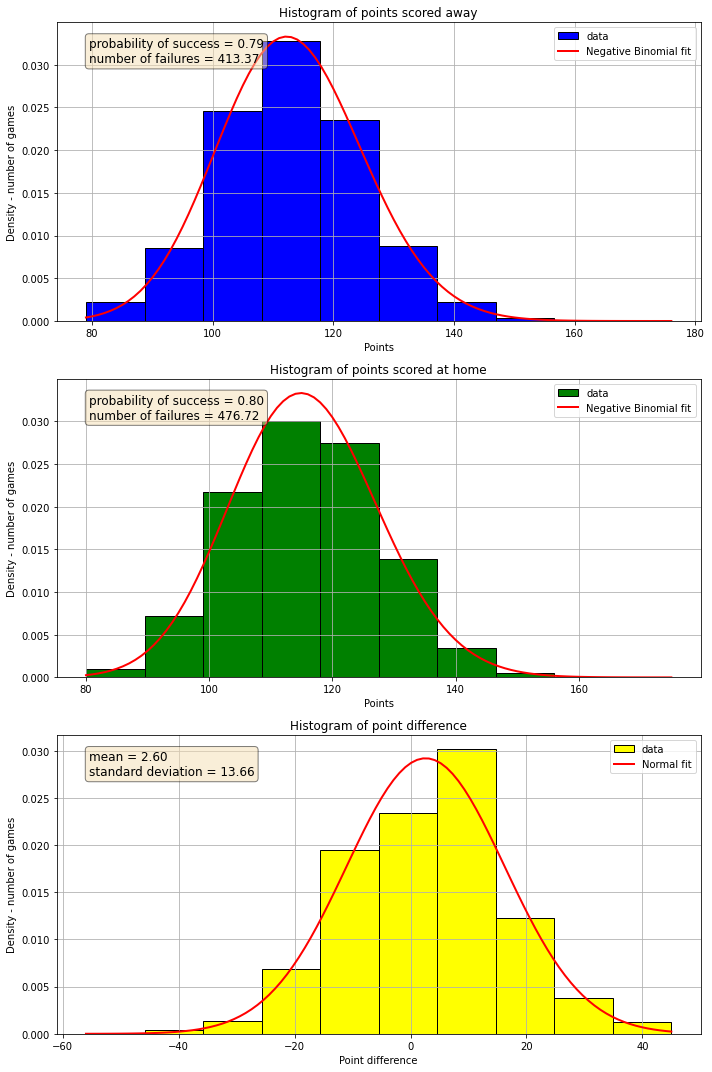

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=10, color='blue', edgecolor='black', label='data')
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=10, color='green', edgecolor='black', label='data')
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

# Histogram of point difference
axes[2].hist(seasons_games[year]['difference'], density=True, bins=10, color='yellow', edgecolor='black', label='data')
axes[2].set_title('Histogram of point difference')
axes[2].set_xlabel('Point difference')
axes[2].set_ylabel('Density - number of games')

# Plot the negative binomial PDF on each chart
for ax, col in zip(axes, ('away_team_score', 'home_team_score', 'difference')):
    mean, var = np.mean(seasons_games[year][col]), np.var(seasons_games[year][col])
    if col == 'difference':
        std = np.sqrt(var)
        x = np.linspace(min(seasons_games[year][col]), max(seasons_games[year][col]), 100)
        normal_pdf = norm.pdf(x, mean, std)
    
        # Plot the normal PDF
        ax.plot(x, normal_pdf, 'r-', lw=2, label='Normal fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    else:
        p = mean / var
        r = mean ** 2 / (var - mean)  # Number of failures
        x = np.arange(min(seasons_games[year][col]), max(seasons_games[year][col]) + 1)
        nbinom_pmf = nbinom.pmf(x, r, p)
            
        # Plot the negative binomial PDF
        ax.plot(x, nbinom_pmf, 'r-', lw=2, label='Negative Binomial fit')
        
        textstr = f'probability of success = {p:.2f}\nnumber of failures = {r:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    ax.legend()
    ax.grid()

plt.tight_layout()

Prepare input data

In [71]:
inp_data = {
    'teams_number': len(teams),
    'games_number': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_score': seasons_games[train_year].home_team_score.to_numpy(),
    'away_score': seasons_games[train_year].away_team_score.to_numpy(),
}

Modelling

Model 1 - posterior

In [72]:
with open('src/model/model_1_posterior.stan', 'r') as f:
    print(f.read())

data {
  int teams_number;
  int games_number;
  array[games_number] int home_team;
  array[games_number] int away_team;
  array[games_number] int<lower=0> home_score;
  array[games_number] int<lower=0> away_score;
}

parameters {
  real mu_home_att;
  real mu_away_att;
  real mu_home_def;
  real mu_away_def;
  real<lower=0> sigma2_att;
  real<lower=0> sigma2_def;
  real<lower=0> phi_home;
  real<lower=0> phi_away;

  vector[teams_number-1] home_att_raw;
  vector[teams_number-1] away_att_raw;
  vector[teams_number-1] home_def_raw;
  vector[teams_number-1] away_def_raw;
}

transformed parameters {
  vector[games_number] log_mu_home;
  vector[games_number] log_mu_away;
  vector[teams_number] home_att;
  vector[teams_number] away_att;
  vector[teams_number] home_def;
  vector[teams_number] away_def;

  // need to make sum(att)=sum(def)=0
  for (k in 1:(teams_number-1)) {
    home_att[k] = home_att_raw[k];
    away_att[k] = away_att_raw[k];
    home_def[k] = home_def_raw[k];
    away_def[k

In [73]:
model_1_prior = CmdStanModel(stan_file='src/model/model_1_posterior.stan')
samples = 1000
sim=model_1_prior.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=False,
                     refresh=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


In [74]:
mod_1_post = sim.draws_pd()
mod_1_post.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_home_att,mu_away_att,mu_home_def,...,away_def[21],away_def[22],away_def[23],away_def[24],away_def[25],away_def[26],away_def[27],away_def[28],away_def[29],away_def[30]
0,-35454.7,0.0,14.3855,0.0,1.0,1.0,35520.4,-1.38748,-1.38753,0.255874,...,0.256434,0.453065,0.958928,-1.59795,1.36827,-0.764239,1.19282,-1.30619,0.956796,14.4447
1,-35454.7,0.0,14.3855,0.0,1.0,1.0,35514.3,-1.38748,-1.38753,0.255874,...,0.256434,0.453065,0.958928,-1.59795,1.36827,-0.764239,1.19282,-1.30619,0.956796,14.4447
2,-35454.7,0.0,14.3855,0.0,1.0,1.0,35511.6,-1.38748,-1.38753,0.255874,...,0.256434,0.453065,0.958928,-1.59795,1.36827,-0.764239,1.19282,-1.30619,0.956796,14.4447
3,-35454.7,0.0,14.3855,0.0,1.0,1.0,35522.7,-1.38748,-1.38753,0.255874,...,0.256434,0.453065,0.958928,-1.59795,1.36827,-0.764239,1.19282,-1.30619,0.956796,14.4447
4,-35454.7,0.0,14.3855,0.0,1.0,1.0,35516.3,-1.38748,-1.38753,0.255874,...,0.256434,0.453065,0.958928,-1.59795,1.36827,-0.764239,1.19282,-1.30619,0.956796,14.4447


/tmp/ipykernel_18897/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


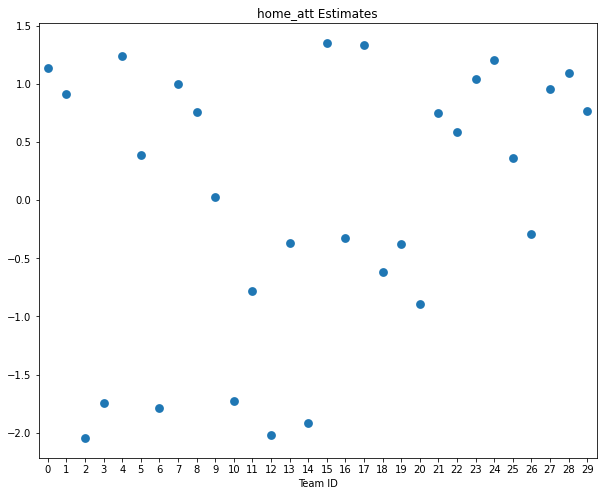

/tmp/ipykernel_18897/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


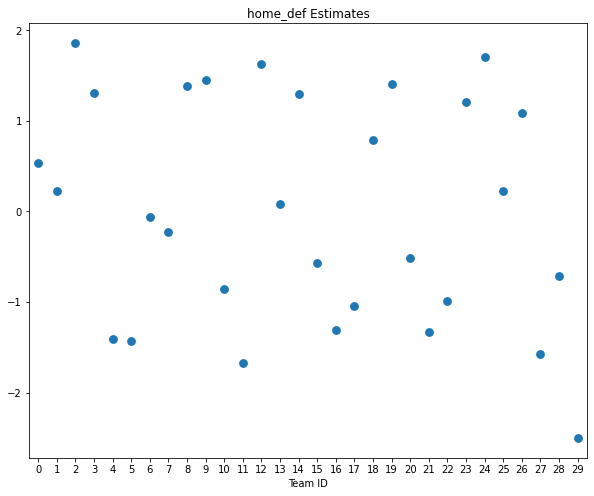

/tmp/ipykernel_18897/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


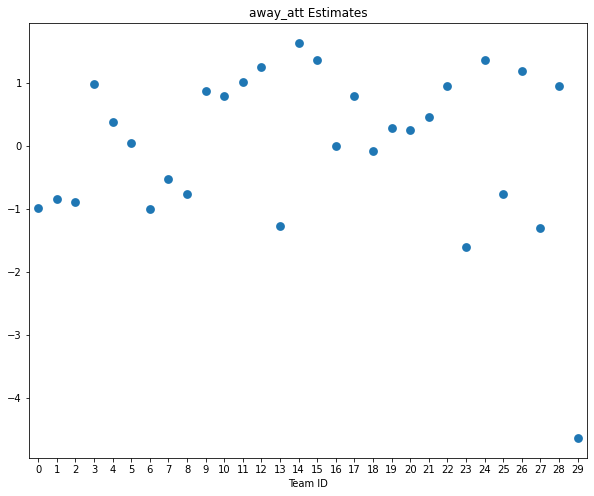

/tmp/ipykernel_18897/4048663389.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


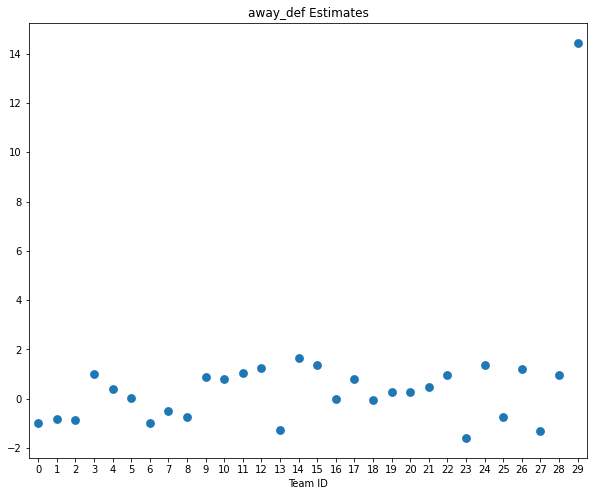

In [75]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
    
for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)
    ax.set_xticks(range(len(teams)))
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    plt.show()

Predicting

In [76]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
param_dict = {param: sim.stan_variable(param) for param in parameters}


# Extracting the samples that we need
for idx, row in seasons_games[pred_year].iterrows():
    print(row)
    print(type(row))
    home_idx = row['home_team_id']
    away_idx = row['away_team_id']
    home_att = param_dict['home_att'][:, home_idx]
    home_def = param_dict['home_def'][:, away_idx]
    away_att = param_dict['away_att'][:, home_idx]
    away_def = param_dict['away_def'][:, away_idx]
    size_home = param_dict['phi_home']
    size_away = param_dict['phi_away']
    
    # Creating the log_mu parameters
    log_mu1 = home_att + away_def
    log_mu2 = home_def + away_att
    
    # Simulating from a negative binomial distribution to obtain predictive distribution
    y1 = np.array([nbinom.rvs(size=size_home[i], p=np.exp(log_mu1[i]) / (np.exp(log_mu1[i]) + size_home[i])) for i in range(samples)])
    y2 = np.array([nbinom.rvs(size=size_away[i], p=np.exp(log_mu2[i]) / (np.exp(log_mu2[i]) + size_away[i])) for i in range(samples)])
    
    # predicted_scores = [np.bincount(y1, minlength=7), np.bincount(y2, minlength=7)]
    
    # A = np.zeros(7)
    # B = np.zeros(7)
    # for i in range(6):
    #     A[i] = predicted_scores[0][i] / np.sum(predicted_scores[0])
    #     B[i] = predicted_scores[1][i] / np.sum(predicted_scores[1])
    
    # A[6] = 1 - np.sum(A[:6])
    # B[6] = 1 - np.sum(B[:6])
    
    # name = ["0", "1", "2", "3", "4", "5", "6+"]
    # C = pd.DataFrame(index=name, columns=name)
    
    # for i in range(7):
    #     for j in range(7):
    #         C.iloc[i, j] = A[j] * B[i]
    
    # # Return predicted scores along with the home and away team for reference
    # predictions = {'HomeTeam': home_team, 'AwayTeam': away_team, 'score_probabilities': C}
    
    outcome_probabilities = pd.DataFrame({
            'home_team_win_prob': [np.mean(y1 > y2)],
            'draw_prob': [np.mean(y1 == y2)],
            'away_team_win_prob': [np.mean(y1 < y2)]
        })

start_time         2022-10-18 23:30:00+00:00
away_team                 PHILADELPHIA 76ERS
away_team_score                          117
home_team                     BOSTON CELTICS
home_team_score                          126
difference                                 9
home_team_id                              21
away_team_id                              20
Name: 0, dtype: object
<class 'pandas.core.series.Series'>


KeyError: 'phi_home'

In [108]:
with open('src/model/model_2.stan', 'r') as f:
    print(f.read())

data {
  int teams_number;
  int games_number;
  array[games_number] int home_team;
  array[games_number] int away_team;
  array[games_number] int<lower=0> home_score;
  array[games_number] int<lower=0> away_score;
}
parameters {
  real mu_home_att;
  real mu_away_att;
  real mu_home_def;
  real mu_away_def;
  real<lower=0> sigma2_att;
  real<lower=0> sigma2_def;

  vector[teams_number-1] home_att_raw;
  vector[teams_number-1] away_att_raw;
  vector[teams_number-1] home_def_raw;
  vector[teams_number-1] away_def_raw;
}
transformed parameters {
  vector[games_number] log_mu_home;
  vector[games_number] log_mu_away;
  vector[teams_number] home_att;
  vector[teams_number] away_att;
  vector[teams_number] home_def;
  vector[teams_number] away_def;

  // need to make sum(att)=sum(def)=0
  for (k in 1:(teams_number-1)) {
    home_att[k] = home_att_raw[k];
    away_att[k] = away_att_raw[k];
    home_def[k] = home_def_raw[k];
    away_def[k] = away_att_raw[k];
  }
  home_att[teams_number] = -s

In [137]:
model_2 = CmdStanModel(stan_file='src/model/model_2.stan')
samples = 1000
sim=model_2.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=False,
                     refresh=samples)

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [138]:
mod_2 = sim.draws_pd()
mod_2.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu_home_att,mu_away_att,mu_home_def,...,away_def[21],away_def[22],away_def[23],away_def[24],away_def[25],away_def[26],away_def[27],away_def[28],away_def[29],away_def[30]
0,-165954.0,0.0,14.3855,0.0,1.0,1.0,166025.0,0.737557,0.737987,-0.432254,...,-1.43218,-0.061584,-1.19383,1.35335,0.800006,-0.375199,1.27407,0.821009,1.70782,6.74689
1,-165954.0,0.0,14.3855,0.0,1.0,1.0,166008.0,0.737557,0.737987,-0.432254,...,-1.43218,-0.061584,-1.19383,1.35335,0.800006,-0.375199,1.27407,0.821009,1.70782,6.74689
2,-165954.0,0.0,14.3855,0.0,1.0,1.0,166013.0,0.737557,0.737987,-0.432254,...,-1.43218,-0.061584,-1.19383,1.35335,0.800006,-0.375199,1.27407,0.821009,1.70782,6.74689
3,-165954.0,0.0,14.3855,0.0,1.0,1.0,166011.0,0.737557,0.737987,-0.432254,...,-1.43218,-0.061584,-1.19383,1.35335,0.800006,-0.375199,1.27407,0.821009,1.70782,6.74689
4,-165954.0,0.0,14.3855,0.0,1.0,1.0,166027.0,0.737557,0.737987,-0.432254,...,-1.43218,-0.061584,-1.19383,1.35335,0.800006,-0.375199,1.27407,0.821009,1.70782,6.74689


2023


/tmp/ipykernel_18897/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


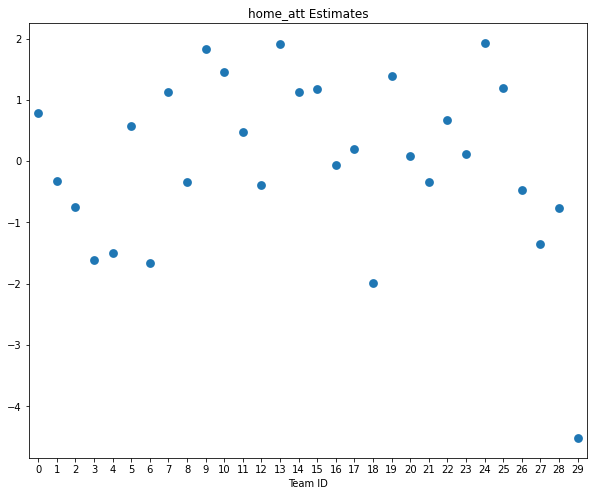

/tmp/ipykernel_18897/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


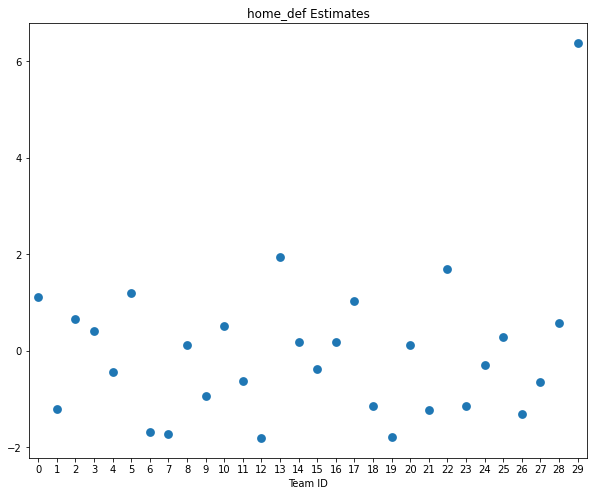

/tmp/ipykernel_18897/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


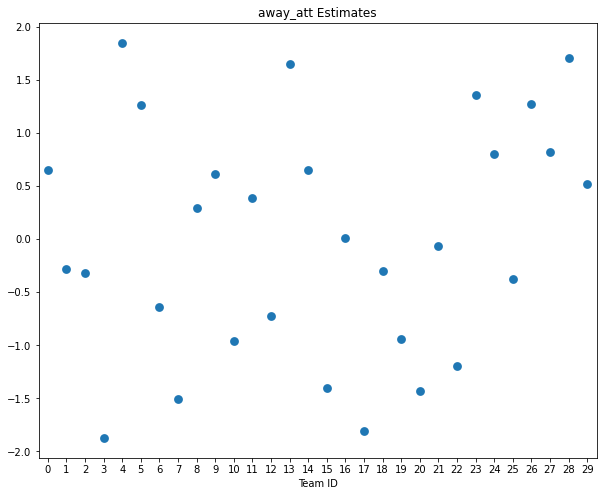

/tmp/ipykernel_18897/1901264299.py:5: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)


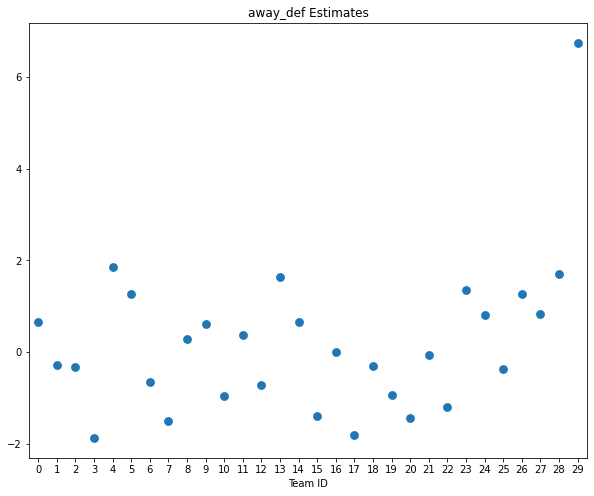

In [139]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
print(year)
for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.pointplot(data=sim.stan_variable(param), ax=ax, join=False)
    ax.set_xticks(range(len(teams)))
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    plt.show()

In [140]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']
param_dict = {param: sim.stan_variable(param) for param in parameters}

# Przykładowe dane do przewidywania (przykładowe ID drużyn)
seasons_games = {
    pred_year: pd.DataFrame({
        'home_team_id': [0, 1, 2],  # Przykładowe ID drużyn domowych
        'away_team_id': [1, 2, 0],   # Przykładowe ID drużyn wyjazdowych
        'home_team_score': [115, 110, 90],
        'away_team_score': [90, 110, 100]
    })
}

# Przewidywanie wyników dla każdego meczu
for idx, row in seasons_games[pred_year].iterrows():
    home_idx = row['home_team_id']
    away_idx = row['away_team_id']
    home_score = row['home_team_score']
    away_score = row['away_team_score']
    
    # Pobieranie odpowiednich parametrów dla drużyn
    home_att = param_dict['home_att'][:, home_idx]
    home_def = param_dict['home_def'][:, away_idx]
    away_att = param_dict['away_att'][:, home_idx]
    away_def = param_dict['away_def'][:, away_idx]
    
    # Tworzenie parametrów log_mu
    log_mu1 = home_att + away_def + np.log(home_score)
    log_mu2 = home_def + away_att + np.log(away_score)
    
    # Symulowanie z rozkładu Poissona dla uzyskania predyktywnej dystrybucji
    y1 = np.array([poisson.rvs(np.exp(log_mu1[i])) for i in range(samples)])
    y2 = np.array([poisson.rvs(np.exp(log_mu2[i])) for i in range(samples)])
    print(y1)
    # draw blocked
    y1 = y1 + (y1 == y2) * np.random.choice([-1, 1], size=samples)
    
    # Obliczanie prawdopodobieństw wyników
    outcome_probabilities = pd.DataFrame({
        'home_team_win_prob': [np.mean(y1 > y2)],
        'away_team_win_prob': [np.mean(y1 < y2)]
    })
    
    print(outcome_probabilities)

[167 226 210 200 188 179 199 202 176 197 182 163 185 168 218 188 179 176
 176 207 201 205 209 176 180 185 179 194 179 197 197 187 221 199 178 200
 211 172 189 184 201 190 203 205 199 226 183 200 183 195 205 200 183 207
 209 217 209 179 183 192 184 168 189 203 220 170 207 182 178 175 196 197
 194 192 193 192 191 203 176 192 181 191 183 179 163 186 196 181 203 193
 199 183 207 165 185 214 194 166 198 185 174 197 166 214 176 180 170 193
 186 197 200 185 197 204 189 187 179 198 205 177 182 193 183 208 178 222
 202 205 169 177 198 198 184 181 185 166 208 187 207 203 190 199 197 175
 222 181 198 189 205 181 163 200 197 198 205 176 190 228 205 181 187 211
 183 203 167 216 173 211 186 186 204 186 203 175 191 196 178 199 185 190
 181 210 207 204 191 211 176 172 190 195 194 194 188 209 202 172 199 172
 199 169 188 185 196 191 178 211 187 170 179 209 206 175 177 185 186 202
 204 193 185 203 196 233 189 178 194 211 180 205 219 177 193 198 183 202
 199 212 193 173 225 204 172 190 205 203 199 196 19